<a href="https://colab.research.google.com/github/kotini-1234/Fish-Species-Classification-using-Deep-Learning/blob/main/CNNusingAGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
# print all columns
pd.set_option('display.max_columns', None)

# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.png'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # filter folders with GT (Ground Truth) at the end
    df = df[df['Labels'].apply(lambda l: l[-2:] != 'GT')]
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)

df = load_data('/content/drive/MyDrive/Fish_Dataset')


In [ ]:
IMG_SIZE = [224, 224]

vgg = VGG16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet', include_top=False)

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg.layers:
 layer.trainable = False


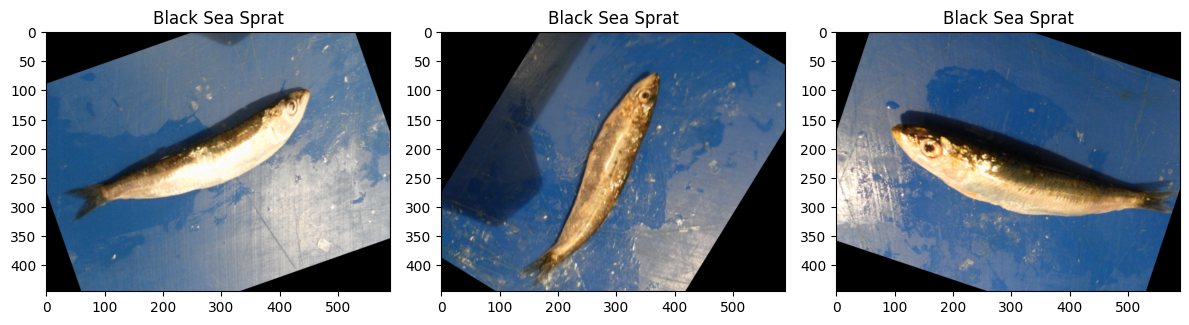

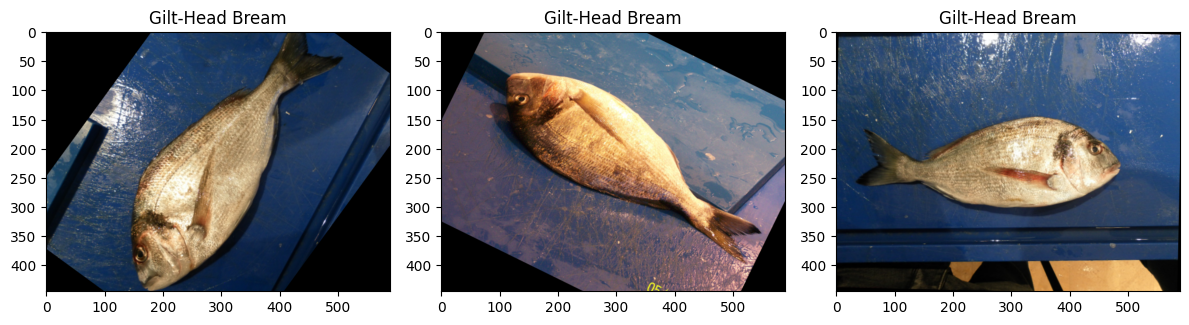

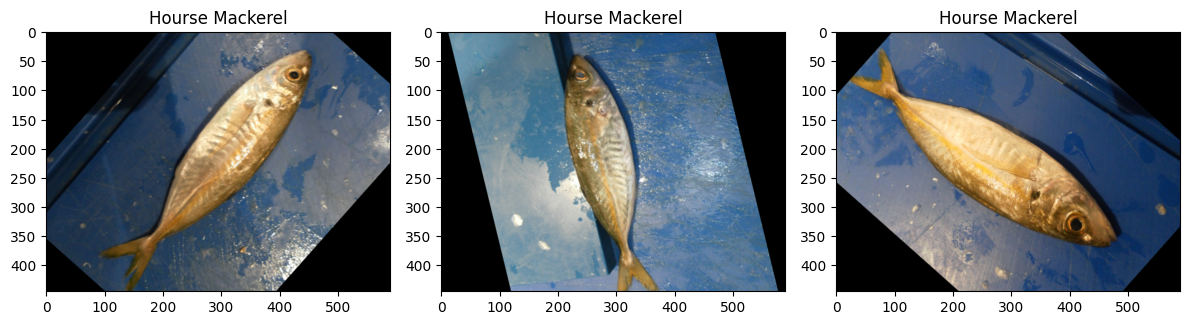

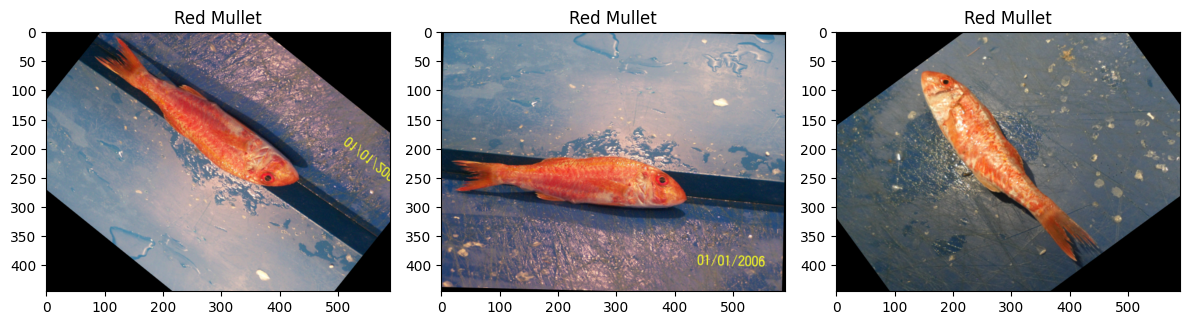

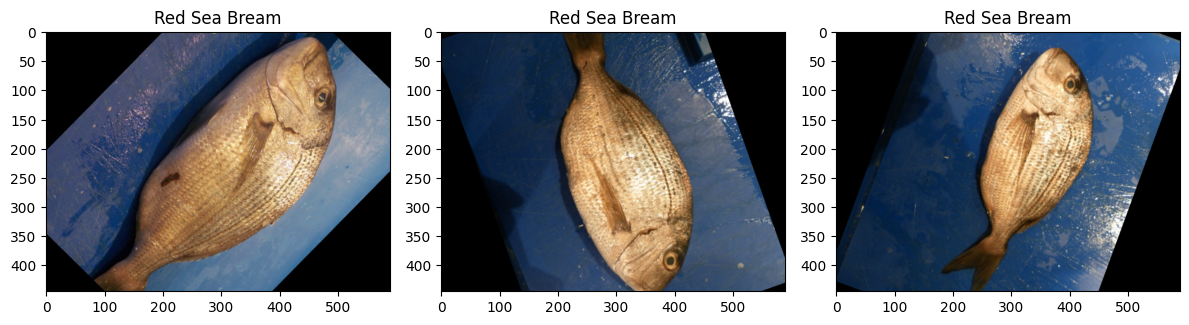

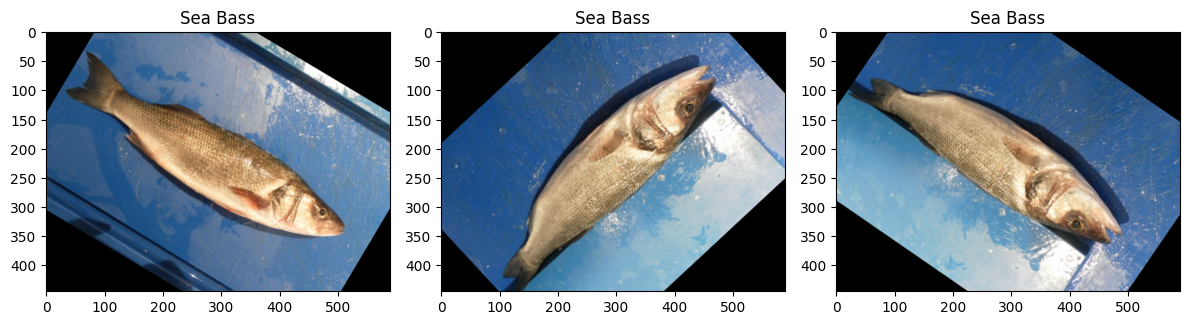

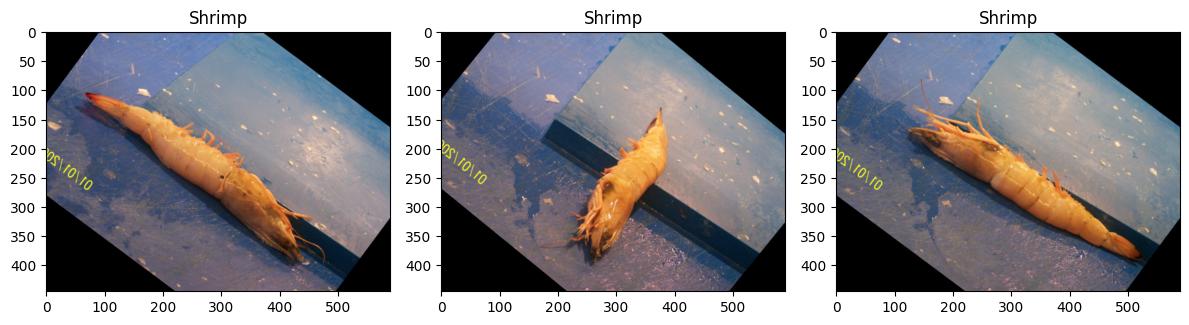

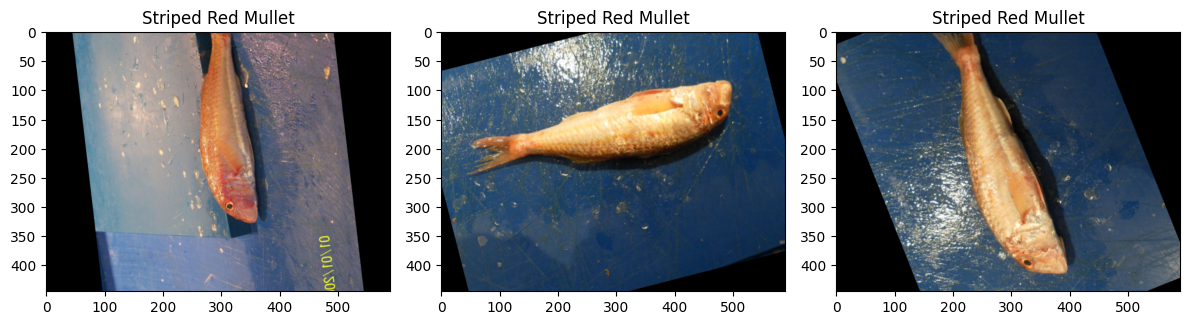

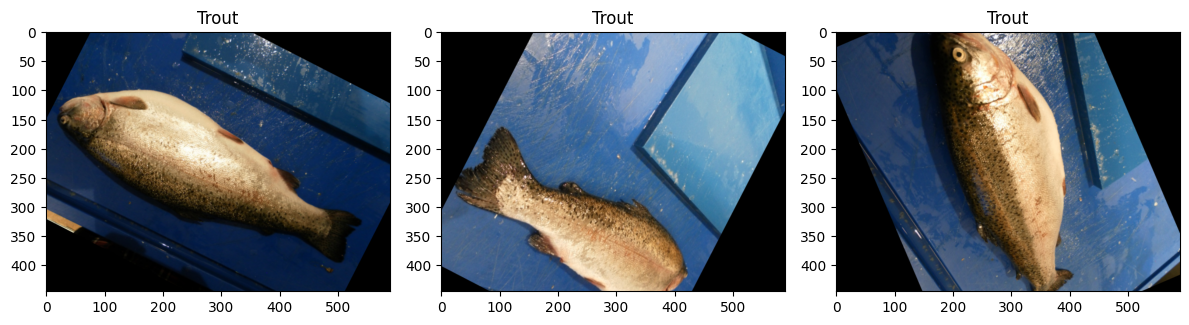

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break

    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

In [ ]:
print(f"Rows: {df.shape[0]}\nColumns: {df.shape[1]} ")

Rows: 9020
Columns: 2 


In [ ]:
df['Labels'].value_counts(ascending=True)

Labels
Black Sea Sprat       1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Shrimp                1000
Red Mullet            1000
Hourse Mackerel       1000
Trout                 1000
Red Sea Bream         1000
Sea Bass              1020
Name: count, dtype: int64

In [ ]:
# stratisfied train and test (10%) datasets
X_train, X_test = train_test_split(df, test_size=0.1, stratify=df['Labels'])
# stratisfied train and val (20%) datasets
X_train, X_val = train_test_split(X_train, test_size=0.2, stratify=X_train['Labels'])

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_train['Labels'].value_counts(ascending=True)

Train Data:  (6494, 2)
Val Data:  (1624, 2)
Test Data:  (902, 2)


Labels
Red Sea Bream         720
Striped Red Mullet    720
Trout                 720
Black Sea Sprat       720
Gilt-Head Bream       720
Red Mullet            720
Hourse Mackerel       720
Shrimp                720
Sea Bass              734
Name: count, dtype: int64

In [ ]:
# number of samples/images per iteration
BATCH_SIZE = 32

EPOCHS = 10

# image preprocessing
train_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

X_train = train_data_gen.flow_from_dataframe(dataframe=X_train,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_val = train_data_gen.flow_from_dataframe(dataframe=X_val,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_test = test_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary for confusion matrix
                                          seed=42)

Found 6494 validated image filenames belonging to 9 classes.
Found 1624 validated image filenames belonging to 9 classes.
Found 902 validated image filenames belonging to 9 classes.


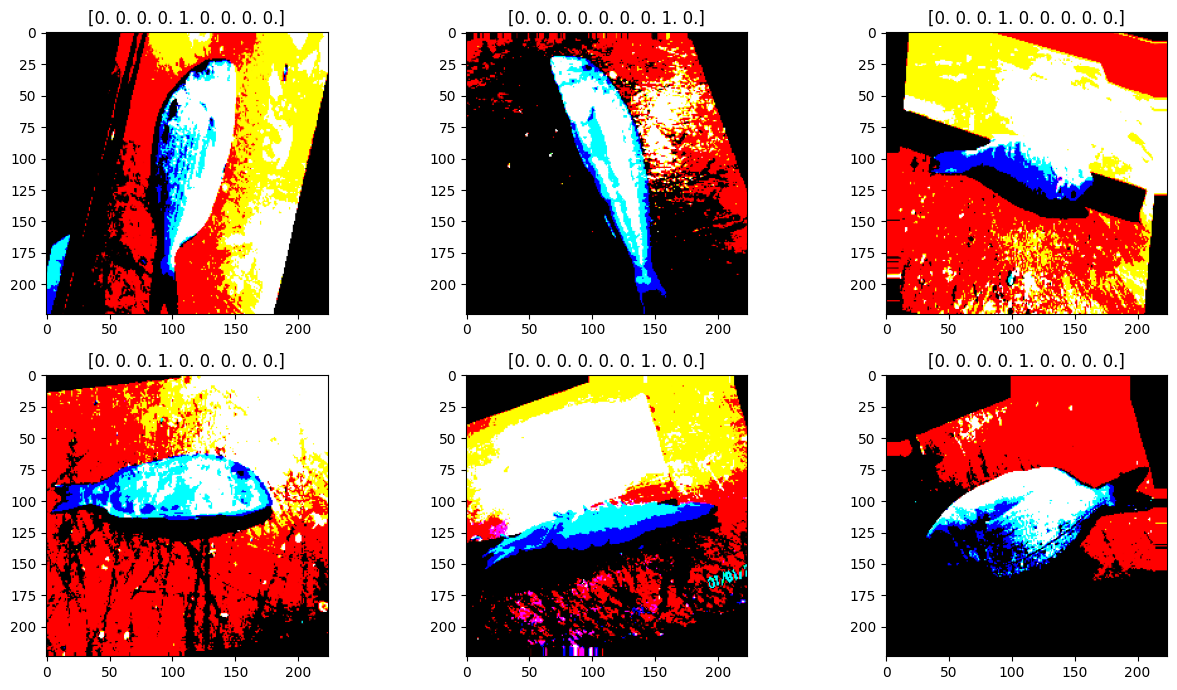

In [ ]:
fit, ax = plt.subplots(nrows=2, ncols=3, figsize=(13,7))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(str(label[0]))


plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()
# scale image size to 0..1
model.add(tf.keras.layers.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(256))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.2))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/10
203/203 [==============================] - 3184s 16s/step - loss: 1.3878 - accuracy: 0.4994 - val_loss: 0.8432 - val_accuracy: 0.6909
Epoch 2/10
203/203 [==============================] - 1071s 5s/step - loss: 0.6550 - accuracy: 0.7616 - val_loss: 0.3721 - val_accuracy: 0.8707
Epoch 3/10
203/203 [==============================] - 1117s 5s/step - loss: 0.3252 - accuracy: 0.8877 - val_loss: 0.2054 - val_accuracy: 0.9218
Epoch 4/10
203/203 [==============================] - 1131s 6s/step - loss: 0.2040 - accuracy: 0.9255 - val_loss: 0.1668 - val_accuracy: 0.9464
Epoch 5/10
203/203 [==============================] - 1130s 6s/step - loss: 0.1526 - accuracy: 0.9464 - val_loss: 0.1199 - val_accuracy: 0.9557
Epoch 6/10
203/203 [==============================] - 1145s 6s/step - loss: 0.1130 - accuracy: 0.9607 - val_loss: 0.0639 - val_accuracy: 0.9803
Epoch 7/10
203/203 [==============================] - 1139s 6s/step - loss: 0.0921 - accuracy: 0.9684 - val_loss: 0.0518 - val_accuracy

In [ ]:
model.save_weights('model1',save_format='tf', overwrite=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None   0         
                             )                                   
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 activation_1 (Activation)   (None, None, None, 64)    0

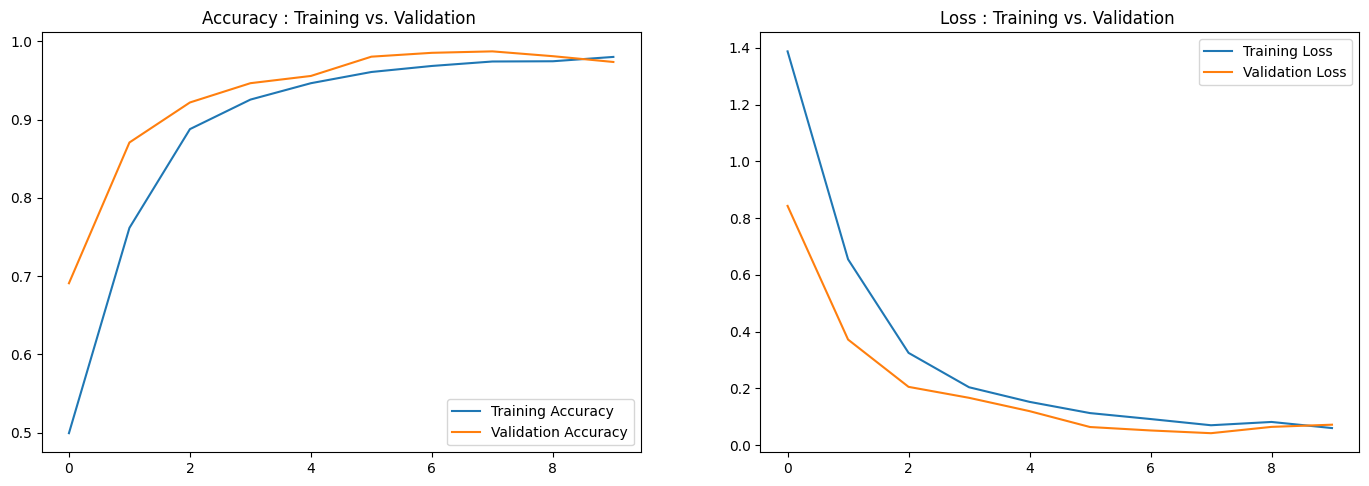

In [ ]:
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

In [ ]:
res = model.evaluate(X_test)

29/29 [==============================] - 353s 13s/step - loss: 0.0396 - accuracy: 0.9878


In [ ]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 98.00
Val Accuracy: 97.35
Test Accuracy: 98.78
Train Loss: 6.02
Val Loss: 7.21
Test Loss: 3.96


In [ ]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

29/29 [==============================] - 49s 2s/step
Y_pred (902, 9)
y_pred 902


In [ ]:

# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 902
labels 9


[[Text(0.5, 0, 'Black Sea Sprat'),
  Text(1.5, 0, 'Gilt-Head Bream'),
  Text(2.5, 0, 'Hourse Mackerel'),
  Text(3.5, 0, 'Red Mullet'),
  Text(4.5, 0, 'Red Sea Bream'),
  Text(5.5, 0, 'Sea Bass'),
  Text(6.5, 0, 'Shrimp'),
  Text(7.5, 0, 'Striped Red Mullet'),
  Text(8.5, 0, 'Trout')],
 [Text(0, 0.5, 'Black Sea Sprat'),
  Text(0, 1.5, 'Gilt-Head Bream'),
  Text(0, 2.5, 'Hourse Mackerel'),
  Text(0, 3.5, 'Red Mullet'),
  Text(0, 4.5, 'Red Sea Bream'),
  Text(0, 5.5, 'Sea Bass'),
  Text(0, 6.5, 'Shrimp'),
  Text(0, 7.5, 'Striped Red Mullet'),
  Text(0, 8.5, 'Trout')]]

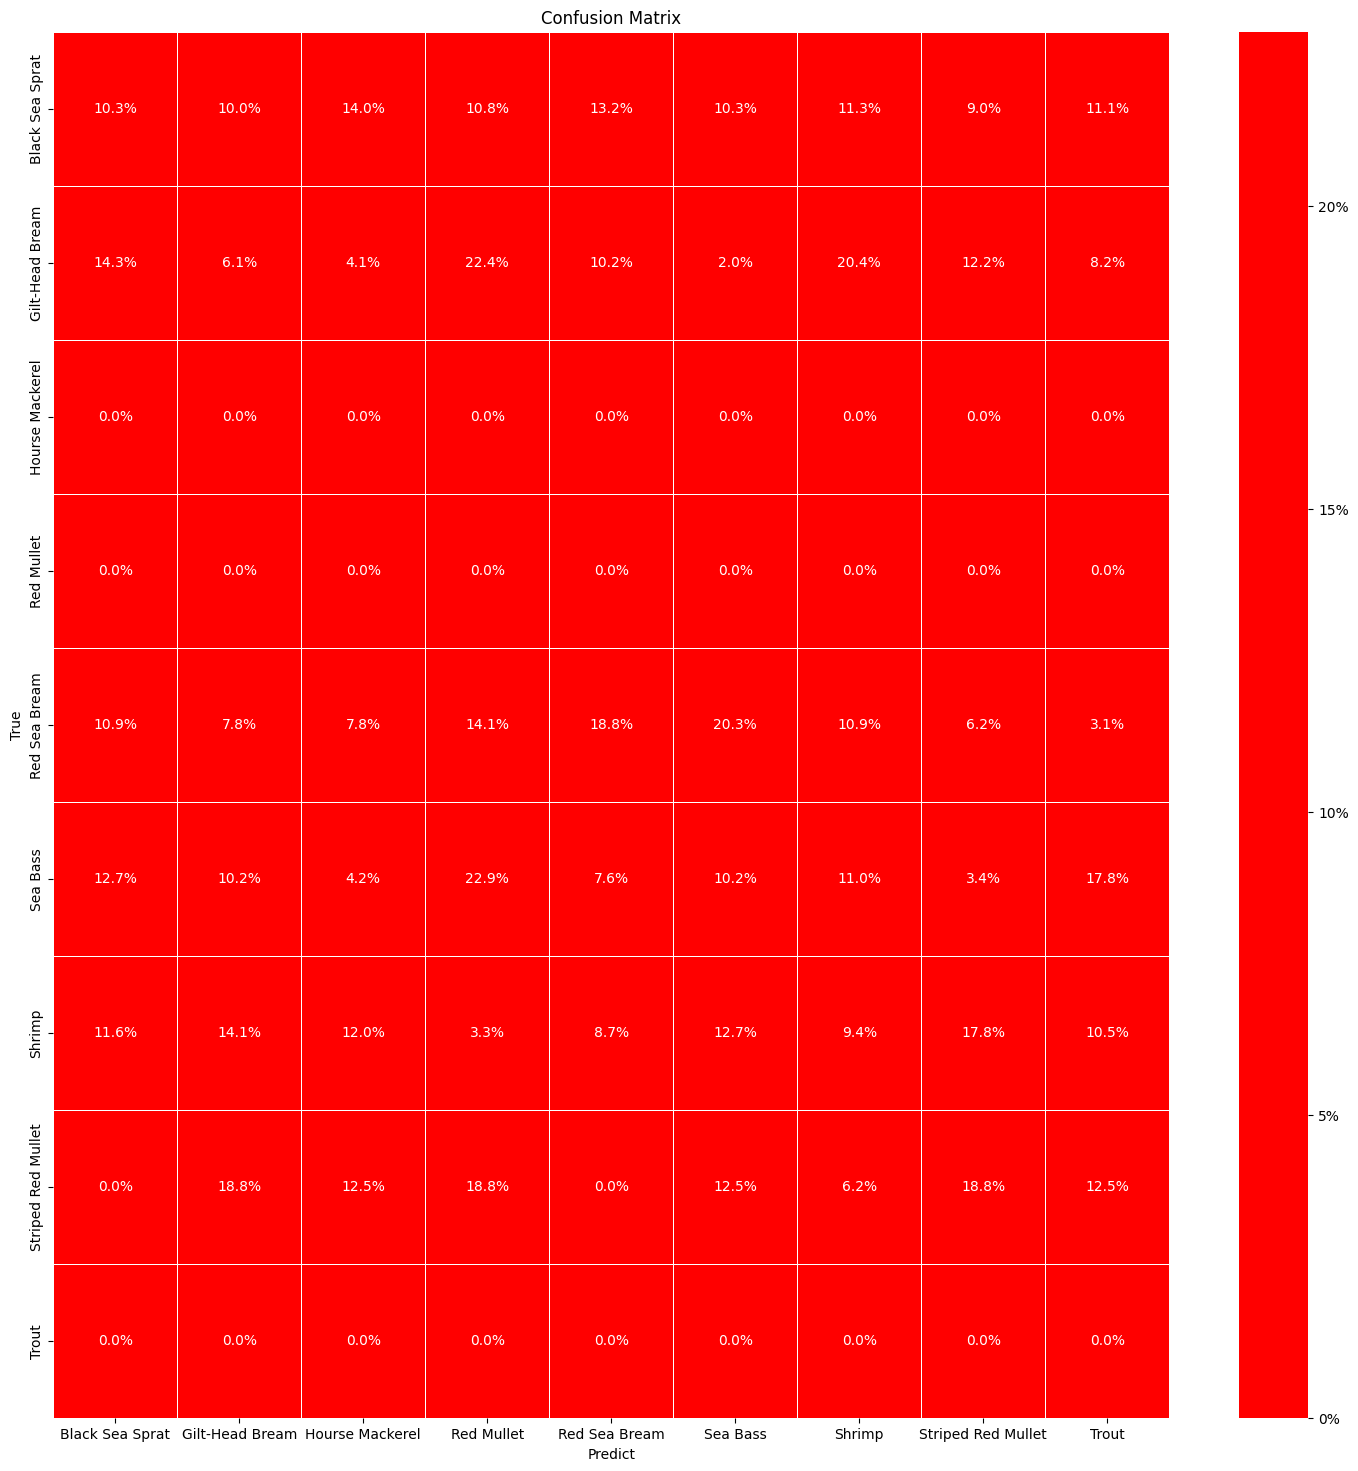

In [ ]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sb.heatmap(cfm,
                annot=True,
                cmap=['#ff0000', '#09AA00'],
                center=0.8,
                fmt='.1%',
                linewidths=.5,
                cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage'
                linecolor='white',
                ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set(xticklabels=class_labels, yticklabels=class_labels)